# Deterministic Model 02: Nastavení modelových parametrů a proces modelování.

In [1]:
# Instalace potřebných knihoven
#%pip install pandas
#%pip install numpy

#%pip install seaborn

In [2]:
# Import potřebných knihoven
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Načtení reálných dat a dat digitálního kladečského plánu

In [3]:
# Soubor je načten a přiřazen do proměnné ‚df"
other_path = '../../data/02_DetermModel/real_data.csv'
df = pd.read_csv(other_path, header=0)

In [4]:
# Zobrazení prvních 5 řádků datasetu
print('Prvních 5 řádků datového rámce')
df.head(5)

Prvních 5 řádků datového rámce


,id,x,y,z,time,delay,type_delay,total_time
0,150,1315,220,1000,29,0,0,29
1,75,220,1190,500,33,0,0,33
2,239,220,940,2000,35,6,3,41
3,199,1315,220,1500,36,0,0,36
4,51,3690,220,250,50,0,0,50


### Definice a nastavení parametrů robotického systému

In [5]:
# SPECIFIKACE ROBOTICKÉHO SYSTÉMU

speed_load = 0.5      # m/s, nastavená rychlost TCP při manipulaci s prvkem (se zátěží)
speed_unload = 1.0    # m/s, nastavená rychlost TCP bez zátěže
accel = 1                 # m/s^2, nastavené zrychlení TCP

# výpočet času potřebného k dosažení nastavené rychlosti
time_to_load_speed = speed_load / accel
dist_to_load_speed = (1/2) * accel * time_to_load_speed  # uražená dráha při akceleraci

# výpočet času potřebného k dosažení 0 rychlosti
time_to_unload_speed = speed_unload / accel
dist_to_unload_speed = (1/2) * accel * time_to_unload_speed  # uražená dráha při deakceleraci

# pracovní dosah robotického ramene
range_max = 3_904         # mm, maximální pracovní dosah
range_min = 1_912         # mm, minimální pracovní dosah (orientační)

# SPECIFIKACE TECHNOLOGICKÉHO PROCESU ZDĚNÍ

time_refer_2_refer = 20   # s, průměrná doba pohybu z referenčního bodu k referenčnímu bodu (depaletizace, verifikace)
time_mounting = 3         # s, doba manipulaci v cílové poloze (umístění prvku)
brick_thickness = 440     # mm, tloušťka zdicího prvku (Porotherm 440 Profi)
brick_height = 250        # mm, výška zdicího prvku (Porotherm 440 Profi)
brick_width = 250         # mm, šířka zdicího prvku (Porotherm 440 Profi)

# SOUŘADNICE REFERENČNÍHO BODU (nad verifikačním stolem)

refer_x = 2_000           # mm, souřadnice X referenčního bodu
refer_y = 3_500           # mm, souřadnice Y referenčního bodu
refer_z = 1_000           # mm, souřadnice Z referenčního bodu

# POLOHA ROBOTICKÉHO RAMENE

robot_x = 2_250           # mm, souřadnice X základny robotu
robot_y = 2_420           # mm, souřadnice Y základny robotu
robot_z = 1_000           # mm, souřadnice Z základny robotu

### Definice funkce pro výpočet celkové doby pracovního cyklu bez stochstických vlivů

In [ ]:
def calculation_dist(x, y, z):
    """
    Funkce pro výpočet dráhy trajektorie od referenčního bodu k cílové poloze prvku

    Parametry:
    x, y, z (int): souřadnice cílové polohy prvku [mm]

    Návratová hodnota:
    dist (int): dráha trajektorie od referenčního bodu k cílové poloze prvku [mm]
    """
    dist = 0

    # Fáze 1: dráha od referenčního bodu k cílové stěně.
    dist = ((refer_z - (z + brick_height*2))**2 + (refer_x - brick_thickness//2)**2)**(1/2)

    # Fáze 2: dráha ve směru osy X
    if x != brick_thickness / 2:
        dist = dist + abs(x - brick_thickness//2 + brick_width * 2)

    # Fáze 3: dráha ve směru osy Y
    if y != brick_thickness / 2:
        dist = dist + abs(y - refer_y + brick_width * 2)

    return int(dist)


def simulate_time(dist):
    """
    Funkce pro výpočet celkové doby pracovního cyklu robotického zdění.

    Parametry:
    dist (int): dráha trajektorie od referenčního bodu k cílové poloze prvku [mm]

    Návratová hodnota:
    total_time (int): celková doba pracovního cyklu [sek]
    """
    # pevné technologické časy (manipulace a přesuny mezi pevnými body)
    total_time = time_refer_2_refer

    # pohyb s naloženým prvkem (převod mm → m)
    total_time += (dist - dist_to_load_speed) / 1_000 / speed_load

    # manipulace v cílové poloze
    total_time += time_mounting

    # pohyb bez zátěže (zpětný pohyb)
    total_time += (dist - dist_to_unload_speed) / 1_000 / speed_unload

    # započtení akceleračních časů
    total_time += time_to_load_speed + time_to_unload_speed
    return total_time

In [7]:
# Funkce pro výpočet dráhy trajektorie od referenčního bodu k cílové poloze prvku
# Pro každý řádek datového rámce je aplikována funkce calculation_dist
# na základě souřadnic 'x','y','z'.
df['dist'] = df.apply(lambda x : calculation_dist(x['x'],x['y'],x['z']) , axis=1)

# Výpočet simulované celkové doby pracovního cyklu
# Pro každý řádek datového rámce je aplikována funkce simulate_time()
# na základě vzdálenosti 'dist'.
df['time_calc'] = df.apply(lambda x : simulate_time(x['dist']) , axis=1)
df.head()

,id,x,y,z,time,delay,type_delay,total_time,dist,time_calc
0,150,1315,220,1000,29,0,0,29,3443,34.828
1,75,220,1190,500,33,0,0,33,3590,35.269
2,239,220,940,2000,35,6,3,41,4387,37.660
3,199,1315,220,1500,36,0,0,36,3636,35.407
4,51,3690,220,250,50,0,0,50,5767,41.800


In [8]:
df[['time','time_calc','dist']].describe()

,time,time_calc,dist
count,161.000000,161.000000,161.000000
mean,36.285714,36.214224,3905.074534
std,6.771658,3.648337,1216.112302
min,24.000000,30.019000,1840.000000
25%,32.000000,33.124000,2875.000000
50%,35.000000,35.800000,3767.000000
75%,39.000000,38.731000,4744.000000
max,56.000000,44.326000,6609.000000


### Porovnání reálných a odvozených dat bez stochastických vlivů

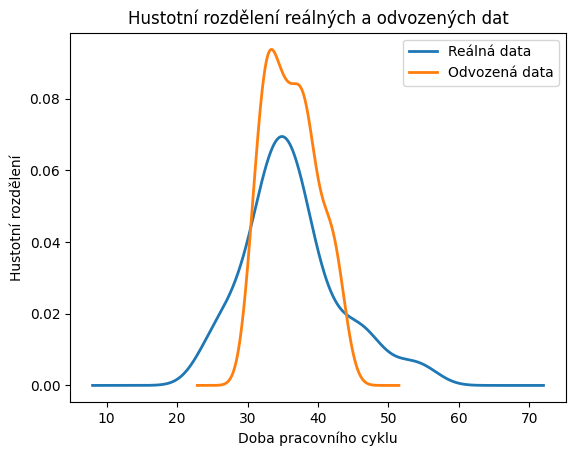

In [9]:
# Graf: Hustotní rozdělení reálných a odvozených dat
df['time'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Reálná data')
df['time_calc'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Odvozená data')
plt.legend()
plt.xlabel("Doba pracovního cyklu")
plt.ylabel("Hustotní rozdělení")
plt.title('Hustotní rozdělení reálných a odvozených dat')
plt.show()

### Simulace přípustných pracovních bodů v prostředí Rhinoceros a Grasshopper (viz. model Rhino)

In [10]:
# Soubor je načten a přiřazen do proměnné ‚df_allowed_points"
other_path = '../../data/02_DetermModel/allowed_points.csv'
df_allowed_points = pd.read_csv(other_path, header=0)

In [11]:
# Změna datového typu sloupců a zobrazení prvních 5 řádků datasetu
df_allowed_points[['x','y','z']] = df_allowed_points[['x','y','z']].astype(int)
df_allowed_points.head(5)

,x,y,z
0,74,459,1284
1,-90,4908,2217
2,522,3074,26
3,425,2247,2739
4,516,3425,1590


### Generování deterministických simulačních dat

In [12]:
# Vytvoření simulačního datového rámce z množiny přípustných bodů
df_sim = df_allowed_points

# Výpočet dráhy trajektorie od referenčního bodu k cílové poloze prvku
df_sim['dist'] = df_sim.apply(
    lambda x: calculation_dist(x['x'], x['y'], x['z']),
    axis=1
)

# Výpočet deterministické doby pracovního cyklu
df_sim['time'] = df_sim.apply(
    lambda x: simulate_time(x['dist']),
    axis=1
)

# Náhled prvních řádků simulovaného datasetu
df_sim.head()

,x,y,z,dist,time
0,74,459,1284,4840,39.019
1,-90,4908,2217,4571,38.212
2,522,3074,26,2718,32.653
3,425,2247,2739,4318,37.453
4,516,3425,1590,3308,34.423


In [13]:
# Základní deskriptivní statistika simulovaného datasetu
df_sim.describe()

,x,y,z,dist,time
count,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000
mean,1422.944700,1336.856500,1374.817600,5858.04950,42.073149
std,1440.916105,1512.725045,805.317921,2172.83209,6.518496
min,-99.000000,-99.000000,0.000000,1984.00000,30.451000
25%,248.000000,202.000000,676.000000,3918.00000,36.253000
50%,599.500000,521.000000,1374.500000,5705.00000,41.614000
75%,2591.250000,2435.000000,2076.000000,7737.25000,47.710750
max,4599.000000,4949.000000,2749.000000,10789.00000,56.866000


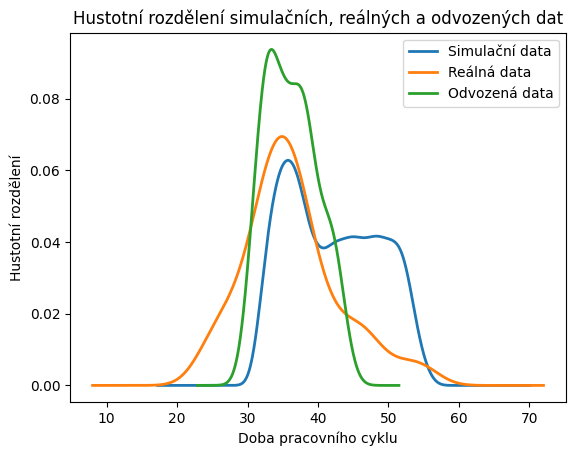

In [14]:
# Graf: Hustotní rozdělení simulačních, reálných a odvozených dat
df_sim['time'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Simulační data')
df['time'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Reálná data')
df['time_calc'].plot.density(bw_method='scott', linestyle='-', linewidth=2, label='Odvozená data')

plt.xlabel("Doba pracovního cyklu")
plt.ylabel("Hustotní rozdělení")
plt.title('Hustotní rozdělení simulačních, reálných a odvozených dat')

plt.legend()
plt.show()

### Export datové sady do formátu CSV

In [15]:
df_sim.to_csv("../../data/02_DetermModel/model_data.csv", index=False)
df.to_csv("../../data/02_DetermModel/model_data_real.csv", index=False)

### Autor / Organizace / Datum

Vjačeslav Usmanov, ČVUT v Praze, Fakulta stavební

###### Přehled změn


|  Datum (YYYY-MM-DD) |  Verze | Autor změny  |  Popis změny |
|---|---|---|---|
| 2026-01-24 | 1.1 | Vjačeslav Usmanov| added DM_02_Model_Parameters.ipynb |
| 2026-02-14 | 1.2 | Vjačeslav Usmanov| changed DM_02_Model_Parameters.ipynb |